**[MSL-01]** 必要なモジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

np.random.seed(20160612)
tf.set_random_seed(20160612)

**[MSL-02]** MNISTのデータセットを用意します。

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
### TensorFlowのバージョンによっては下記のwarningが表示されるが、無視するしかない。
# WARNING:tensorflow:From <ipython-input-2-******>:1: read_data_sets ...
# Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
#...

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


**[MSL-03]** 単層ニューラルネットワークを用いた確率 p の計算式を用意します。

In [3]:
num_units = 1024

x = tf.placeholder(tf.float32, [None, 784])

w1 = tf.Variable(tf.truncated_normal([784, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1)

w0 = tf.Variable(tf.zeros([num_units, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden1, w0) + b0)

**[MSL-04]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [4]:
t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[MSL-05]** セッションを用意して、Variableを初期化します。

In [5]:
### >>> with GPU 80%
#gpuConfig = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(
#        per_process_gpu_memory_fraction = 0.8),
#    device_count = {'GPU':0})
#sess = tf.Session(config = gpuConfig)
### <<<
#
### >>> with CPU only
sess = tf.Session()
### <<<
sess.run(tf.global_variables_initializer())

**[MSL-06]** パラメーターの最適化を2000回繰り返します。

1回の処理において、トレーニングセットから取り出した100個のデータを用いて、勾配降下法を適用します。

最終的に、テストセットに対して約97%の正解率が得られます。

In [6]:
i = 0
for _ in range(2000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, t: batch_ts})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
            feed_dict={x:mnist.test.images, t: mnist.test.labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 100, Loss: 2674.854736, Accuracy: 0.921100
Step: 200, Loss: 2180.231201, Accuracy: 0.933400
Step: 300, Loss: 1980.723145, Accuracy: 0.938600
Step: 400, Loss: 1829.057983, Accuracy: 0.943200
Step: 500, Loss: 1411.335938, Accuracy: 0.954900
Step: 600, Loss: 1390.591431, Accuracy: 0.958900
Step: 700, Loss: 1294.857178, Accuracy: 0.961000
Step: 800, Loss: 1259.285278, Accuracy: 0.962500
Step: 900, Loss: 1251.906372, Accuracy: 0.961600
Step: 1000, Loss: 1164.970093, Accuracy: 0.963500
Step: 1100, Loss: 1148.402222, Accuracy: 0.964600
Step: 1200, Loss: 1125.478760, Accuracy: 0.963500
Step: 1300, Loss: 1056.904419, Accuracy: 0.968300
Step: 1400, Loss: 1005.676697, Accuracy: 0.969500
Step: 1500, Loss: 1082.056641, Accuracy: 0.967400
Step: 1600, Loss: 1016.457336, Accuracy: 0.968100
Step: 1700, Loss: 931.995850, Accuracy: 0.971800
Step: 1800, Loss: 926.855225, Accuracy: 0.972200
Step: 1900, Loss: 1050.111084, Accuracy: 0.969500
Step: 2000, Loss: 1009.358215, Accuracy: 0.968800


**[MSL-07]** 最適化されたパラメーターを用いて、テストセットに対する予測を表示します。

ここでは、「０」〜「９」の数字に対して、正解と不正解の例を３個ずつ表示します。

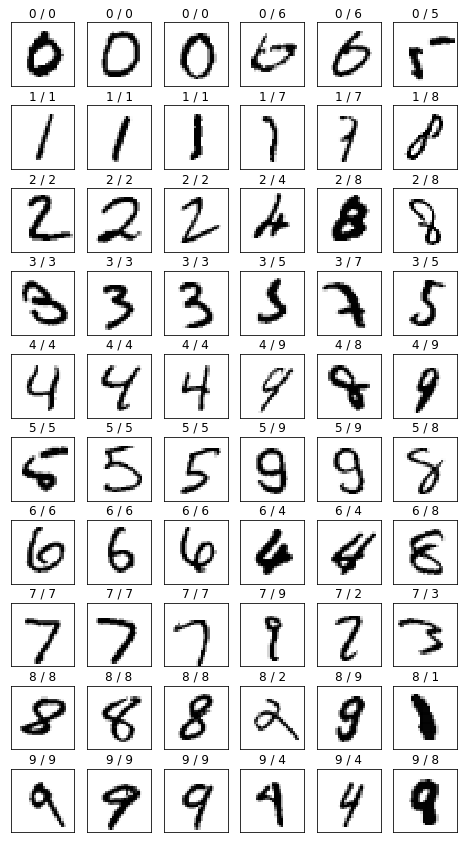

In [7]:
images, labels = mnist.test.images, mnist.test.labels
p_val = sess.run(p, feed_dict={x:images, t: labels}) 

fig = plt.figure(figsize=(8,15))
for i in range(10):
    c = 1
    for (image, label, pred) in zip(images, labels, p_val):
        prediction, actual = np.argmax(pred), np.argmax(label)
        if prediction != i:
            continue
        if (c < 4 and i == actual) or (c >= 4 and i != actual):
            subplot = fig.add_subplot(10,6,i*6+c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.set_title('%d / %d' % (prediction, actual))
            subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                           cmap=plt.cm.gray_r, interpolation="nearest")
            c += 1
            if c > 6:
                break